# ADVANCED ML MODELS 


##  Модели:
1. Random Forest
2. LightGBM
3. CatBoost GPU
4. KNN на фичах (k=50)


In [ ]:
# ========================================
# ADVANCED ML MODELS 
# ========================================

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n" + "="*70)
print(" ADVANCED ML MODELS")
print("   СО ВСЕМИ ДОСТУПНЫМИ ПРИЗНАКАМИ")
print("="*70)


 ADVANCED ML MODELS - ФИНАЛЬНАЯ ВЕРСИЯ
   СО ВСЕМИ ДОСТУПНЫМИ ПРИЗНАКАМИ


## 1. Загрузка ВСЕХ данных

In [16]:
print("\n[1/10] Загрузка ВСЕХ данных...")

# Feature engineering данные (17 числовых признаков)
train_df = pd.read_csv('train_features_full.csv')
test_df = pd.read_csv('test_features_full.csv')

print(f"  Train features: {len(train_df):,} × {train_df.shape[1]}")
print(f"  Test features: {len(test_df):,} × {test_df.shape[1]}")

# Preprocessing embeddings (768-dim книги: tags + title+author)
print("\n   Загрузка train_embeddings.pkl...")
with open('train_embeddings.pkl', 'rb') as f:
    train_embeddings_pkl = pickle.load(f)

with open('test_embeddings.pkl', 'rb') as f:
    test_embeddings_pkl = pickle.load(f)

# Извлекаем book embeddings (768-dim)
train_book_emb = train_embeddings_pkl['book_emb']  # shape: (874496, 768)
test_book_emb = test_embeddings_pkl['book_emb']    # shape: (107260, 768)

print(f"  Train book embeddings: {train_book_emb.shape}")
print(f"  Test book embeddings: {test_book_emb.shape}")



# Baseline для сравнения
with open('baseline_artifacts.pkl', 'rb') as f:
    baseline_artifacts = pickle.load(f)

baseline_rmse = baseline_artifacts['best_baseline_rmse']
print(f"\n  Baseline RMSE to beat: {baseline_rmse:.4f}")


[1/10] Загрузка ВСЕХ данных...
  Train features: 874,496 × 21
  Test features: 107,260 × 21

   Загрузка train_embeddings.pkl...
  Train book embeddings: (874496, 768)
  Test book embeddings: (107260, 768)

  Baseline RMSE to beat: 0.8104


## 2. Создание набора признаков

In [ ]:
print("\n[2/10] Создание набора признаков...")

# 17 числовых признаков из feature_engineering
numeric_features = [
    # Interaction (6)
    'tag_overlap_count', 'tag_overlap_ratio', 'tag_jaccard',
    'history_similarity', 'embedding_cosine_sim', 'embedding_euclidean_dist',
    # User (4)
    'avg_user_rating', 'ratings_count', 'tag_vocab_size', 'activity_score',
    # Book (3)
    'book_avg_rating', 'book_ratings_count', 'book_popularity',
    # Preprocessing (4)
    'language_code_encoded', 'year_normalized', 'publication_era', 'average_rating'
]

# Категориальный признак
cat_feature = 'segment'

# Энкодим segment для моделей без поддержки категориальных
segment_mapping = {'new': 0, 'inactive': 1, 'active': 2, 'very_active': 3}
train_df['segment_encoded'] = train_df[cat_feature].map(segment_mapping).fillna(1)
test_df['segment_encoded'] = test_df[cat_feature].map(segment_mapping).fillna(1)

# Базовый набор: 17 числовых + 1 encoded segment = 18
base_features = numeric_features + ['segment_encoded']

print(f"\n  Категории признаков:")
print(f"   • Interaction features: 6")
print(f"   • User features: 4")
print(f"   • Book features: 3")
print(f"   • Preprocessing features: 4")
print(f"   • Category (segment): 1")
print(f"   • Book embeddings (768-dim): 768")
print(f"\n    Базовый набор: {len(base_features)} признаков")
print(f"    Полный набор: {len(base_features) + 768} признаков")

# Создаем DataFrame с book embeddings
emb_columns = [f'book_emb_{i}' for i in range(768)]
train_emb_df = pd.DataFrame(train_book_emb, columns=emb_columns, index=train_df.index)
test_emb_df = pd.DataFrame(test_book_emb, columns=emb_columns, index=test_df.index)

#  набор признаков
all_features = base_features + emb_columns

print(f"\n  Всего признаков для моделей: {len(all_features)}")
print(f"\n  НЕ используем (избегаем мультиколлинеарность):")
print(f"   • user_id (ID, агрегирован в avg_user_rating)")
print(f"   • book_id (ID, агрегирован в book_avg_rating)")
print(f"   • rating (target, data leakage)")
print(f"   • segment (строка, закодирован в segment_encoded)")


[2/10] Создание ПОЛНОГО набора признаков...

  Категории признаков:
   • Interaction features: 6
   • User features: 4
   • Book features: 3
   • Preprocessing features: 4
   • Category (segment): 1
   • Book embeddings (768-dim): 768

    Базовый набор: 18 признаков
    Полный набор: 786 признаков

  Всего признаков для моделей: 786

  НЕ используем (избегаем мультиколлинеарность):
   • user_id (ID, агрегирован в avg_user_rating)
   • book_id (ID, агрегирован в book_avg_rating)
   • rating (target, data leakage)
   • segment (строка, закодирован в segment_encoded)


## 3. Подготовка данных для моделей

In [ ]:
print("\n[3/10] Подготовка данных...")

# Объединяем базовые признаки с embeddings
train_full = pd.concat([train_df[base_features], train_emb_df], axis=1)
test_full = pd.concat([test_df[base_features], test_emb_df], axis=1)

print(f"  Train full: {train_full.shape}")
print(f"  Test full: {test_full.shape}")

# Проверка на NaN
train_nan = train_full.isnull().sum().sum()
test_nan = test_full.isnull().sum().sum()

if train_nan > 0 or test_nan > 0:
    print(f"\n   NaN найдены: train={train_nan}, test={test_nan}")
    print(f"   Заполняем нулями...")
    train_full = train_full.fillna(0)
    test_full = test_full.fillna(0)
    print(f"  NaN заполнены")
else:
    print(f"  NaN не найдены")

# Target
y_full = train_df['rating'].values
y_test = test_df['rating'].values

# Train/Val split 
print("\n   Создание train/val split...")
X_train, X_val, y_train, y_val = train_test_split(
    train_full, y_full,
    test_size=0.15,
    random_state=42,
    stratify=y_full
)

print(f"  Train: {X_train.shape[0]:,}")
print(f"  Validation: {X_val.shape[0]:,}")
print(f"  Test: {test_full.shape[0]:,}")

# Нормализация для моделей
print("\n   Нормализация признаков...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_full)

print(f"  Scaling завершен")


[3/10] Подготовка данных...
  Train full: (874496, 786)
  Test full: (107260, 786)
  NaN не найдены

   Создание train/val split...
  Train: 743,321
  Validation: 131,175
  Test: 107,260

   Нормализация признаков...
  Scaling завершен


## 4. Функции для метрик

In [ ]:
print("\n[4/10] Настройка функций метрик...")

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Вычисляет метрики с учетом rating buckets"""
    y_pred_clipped = np.clip(y_pred, 1, 5)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_clipped))
    mae = mean_absolute_error(y_true, y_pred_clipped)
    
    low_mask = y_true <= 3
    high_mask = y_true >= 4
    
    rmse_low = np.sqrt(mean_squared_error(y_true[low_mask], y_pred_clipped[low_mask])) if low_mask.sum() > 0 else np.nan
    rmse_high = np.sqrt(mean_squared_error(y_true[high_mask], y_pred_clipped[high_mask])) if high_mask.sum() > 0 else np.nan
    
    results = {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'rmse_low': rmse_low,
        'rmse_high': rmse_high,
        'beats_baseline': rmse < baseline_rmse
    }
    
    return results

def print_metrics(results):
    """Красиво печатает метрики"""

    print(f" • RMSE (overall): {results['rmse']:.4f}")
    print(f" • MAE (overall): {results['mae']:.4f}")
    print(f" • RMSE (low ≤3): {results['rmse_low']:.4f}")
    print(f" • RMSE (high ≥4): {results['rmse_high']:.4f}")
    
    if results['beats_baseline']:
        improvement = (baseline_rmse - results['rmse']) / baseline_rmse * 100
        print(f"  Улучшение vs baseline: {improvement:.2f}%")
    else:
        degradation = (results['rmse'] - baseline_rmse) / baseline_rmse * 100
        print(f"  Хуже baseline на: {degradation:.2f}%")

all_results = []
print("  Функции готовы")


[4/10] Настройка функций метрик...
  Функции готовы


## 5. MODEL 1: Random Forest

In [20]:
print("\n" + "="*70)
print("[5/10] MODEL 1: RANDOM FOREST")
print("="*70)

print("\n Обучение Random Forest (786 признаков)...")

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(test_full)
rf_results = calculate_metrics(y_test, rf_pred, "Random Forest (786 features)")
print_metrics(rf_results)
all_results.append(rf_results)

# Feature importance
print("\n  Top-10 важных признаков:")
feature_importance_rf = pd.DataFrame({
    'feature': all_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance_rf.head(10).iterrows():
    print(f" {row['feature']:40s} {row['importance']:.4f}")


[5/10] MODEL 1: RANDOM FOREST

 Обучение Random Forest (786 признаков)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s



 ⚠️ Random Forest (786 features):
 • RMSE (overall): 0.8272
 • MAE (overall): 0.6605
 • RMSE (low ≤3): 1.1401
 • RMSE (high ≥4): 0.6066
  Хуже baseline на: 2.06%

  Top-10 важных признаков:
 avg_user_rating                          0.3295
 book_avg_rating                          0.0681
 embedding_cosine_sim                     0.0546
 embedding_euclidean_dist                 0.0517
 average_rating                           0.0426
 book_popularity                          0.0346
 activity_score                           0.0161
 tag_vocab_size                           0.0160
 ratings_count                            0.0130
 history_similarity                       0.0113


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


## 6. MODEL 2: LightGBM

In [21]:
print("\n" + "="*70)
print("[6/10] MODEL 2: LIGHTGBM")
print("="*70)

print("\n Обучение LightGBM (786 признаков)...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=50,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

lgb_pred = lgb_model.predict(test_full)
lgb_results = calculate_metrics(y_test, lgb_pred, "LightGBM (786 features)")
print_metrics(lgb_results)
all_results.append(lgb_results)

# Feature importance
print("\n  Top-10 важных признаков (LightGBM):")
lgb_importance = pd.DataFrame({
    'feature': all_features,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in lgb_importance.head(10).iterrows():
    print(f" {row['feature']:40s} {row['importance']:.0f}")


[6/10] MODEL 2: LIGHTGBM

 Обучение LightGBM (786 признаков)...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.754142	valid_0's l2: 0.56873
[200]	valid_0's rmse: 0.744517	valid_0's l2: 0.554306
[300]	valid_0's rmse: 0.740086	valid_0's l2: 0.547727
[400]	valid_0's rmse: 0.737453	valid_0's l2: 0.543837
[500]	valid_0's rmse: 0.735676	valid_0's l2: 0.541219
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.735676	valid_0's l2: 0.541219

 🎉 LightGBM (786 features):
 • RMSE (overall): 0.7869
 • MAE (overall): 0.6019
 • RMSE (low ≤3): 1.0890
 • RMSE (high ≥4): 0.5728
  Улучшение vs baseline: 2.90%

  Top-10 важных признаков (LightGBM):
 embedding_cosine_sim                     1572
 embedding_euclidean_dist                 1495
 avg_user_rating                          1417
 tag_vocab_size                           1231
 ratings_count                            773
 book_avg_rating                          678
 history_similarity   

## 7. MODEL 3: CatBoost GPU

In [22]:
print("\n" + "="*70)
print("[7/10] MODEL 3: CATBOOST GPU")
print("="*70)

print("\n Обучение CatBoost на GPU...")

# Для CatBoost используем базовые признаки + категориальный segment
# + embeddings как числовые
cat_features_cols = base_features[:-1] + [cat_feature]  # без segment_encoded

# Подготовка данных
train_cat_full = pd.concat([train_df[cat_features_cols], train_emb_df], axis=1)

# Split
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    train_cat_full, y_full,
    test_size=0.15,
    random_state=42,
    stratify=y_full
)

test_cat = pd.concat([test_df[cat_features_cols], test_emb_df], axis=1)

# Pool
train_pool = Pool(X_train_cat, y_train_cat, cat_features=[cat_feature])
val_pool = Pool(X_val_cat, y_val_cat, cat_features=[cat_feature])
test_pool = Pool(test_cat, y_test, cat_features=[cat_feature])

catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3,
    task_type='GPU',
    devices='0',
    verbose=100,
    random_state=42
)

catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    early_stopping_rounds=50,
    verbose_eval=100
)

catboost_pred = catboost_model.predict(test_pool)
catboost_results = calculate_metrics(y_test, catboost_pred, "CatBoost GPU (786 features)")
print_metrics(catboost_results)
all_results.append(catboost_results)


[7/10] MODEL 3: CATBOOST GPU

 Обучение CatBoost на GPU...
0:	learn: 0.9686451	test: 0.9685528	best: 0.9685528 (0)	total: 253ms	remaining: 2m 6s
100:	learn: 0.7621475	test: 0.7614793	best: 0.7614793 (100)	total: 8.71s	remaining: 34.4s
200:	learn: 0.7529811	test: 0.7531441	best: 0.7531441 (200)	total: 17.7s	remaining: 26.3s
300:	learn: 0.7479682	test: 0.7489922	best: 0.7489922 (300)	total: 26.3s	remaining: 17.4s
400:	learn: 0.7442046	test: 0.7460664	best: 0.7460664 (400)	total: 35s	remaining: 8.65s
499:	learn: 0.7413013	test: 0.7440221	best: 0.7440221 (499)	total: 43.8s	remaining: 0us
bestTest = 0.7440220995
bestIteration = 499

 🎉 CatBoost GPU (786 features):
 • RMSE (overall): 0.7731
 • MAE (overall): 0.5919
 • RMSE (low ≤3): 1.0658
 • RMSE (high ≥4): 0.5669
  Улучшение vs baseline: 4.60%


## 8. MODEL 4: KNN на базовых фичах

In [23]:
print("\n" + "="*70)
print("[8/10] MODEL 4: KNN НА БАЗОВЫХ ФИЧАХ (18)")
print("="*70)

print("\n Обучение KNN на базовых 18 признаках...")

# Используем только базовые признаки (без embeddings)
X_train_base = X_train[base_features]
X_val_base = X_val[base_features]
X_test_base = test_full[base_features]

# Scaling
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_test_base_scaled = scaler_base.transform(X_test_base)

knn_features = KNeighborsRegressor(
    n_neighbors=50,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)

knn_features.fit(X_train_base_scaled, y_train)

knn_feat_pred = knn_features.predict(X_test_base_scaled)
knn_feat_results = calculate_metrics(y_test, knn_feat_pred, "KNN на базовых фичах (k=50)")
print_metrics(knn_feat_results)
all_results.append(knn_feat_results)


[8/10] MODEL 4: KNN НА БАЗОВЫХ ФИЧАХ (18)

 Обучение KNN на базовых 18 признаках...

 🎉 KNN на базовых фичах (k=50):
 • RMSE (overall): 0.7819
 • MAE (overall): 0.6157
 • RMSE (low ≤3): 1.0747
 • RMSE (high ≥4): 0.5764
  Улучшение vs baseline: 3.51%


## 9. Сравнение и визуализация


[9/9] СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ

 Таблица результатов:
 Model                               RMSE       MAE        RMSE(low)    RMSE(high)   Beat  
 [BASELINE] User+Book                0.8104     -          1.1141       0.6770       -     
 ----------------------------------------------------------------------------------------------------
 Random Forest (786 features)        0.8272     0.6605     1.1401       0.6066       ✅     
 LightGBM (786 features)             0.7869     0.6019     1.0890       0.5728       ✅     
 CatBoost GPU (786 features)         0.7731     0.5919     1.0658       0.5669       ✅     
 KNN на базовых фичах (k=50)         0.7819     0.6157     1.0747       0.5764       ✅     

  Лучшая модель: CatBoost GPU (786 features)
 RMSE: 0.7731
 Улучшение vs baseline: 4.60%

  Моделей лучше baseline: 3/4

 СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ

  График: ml_models_full_features.png


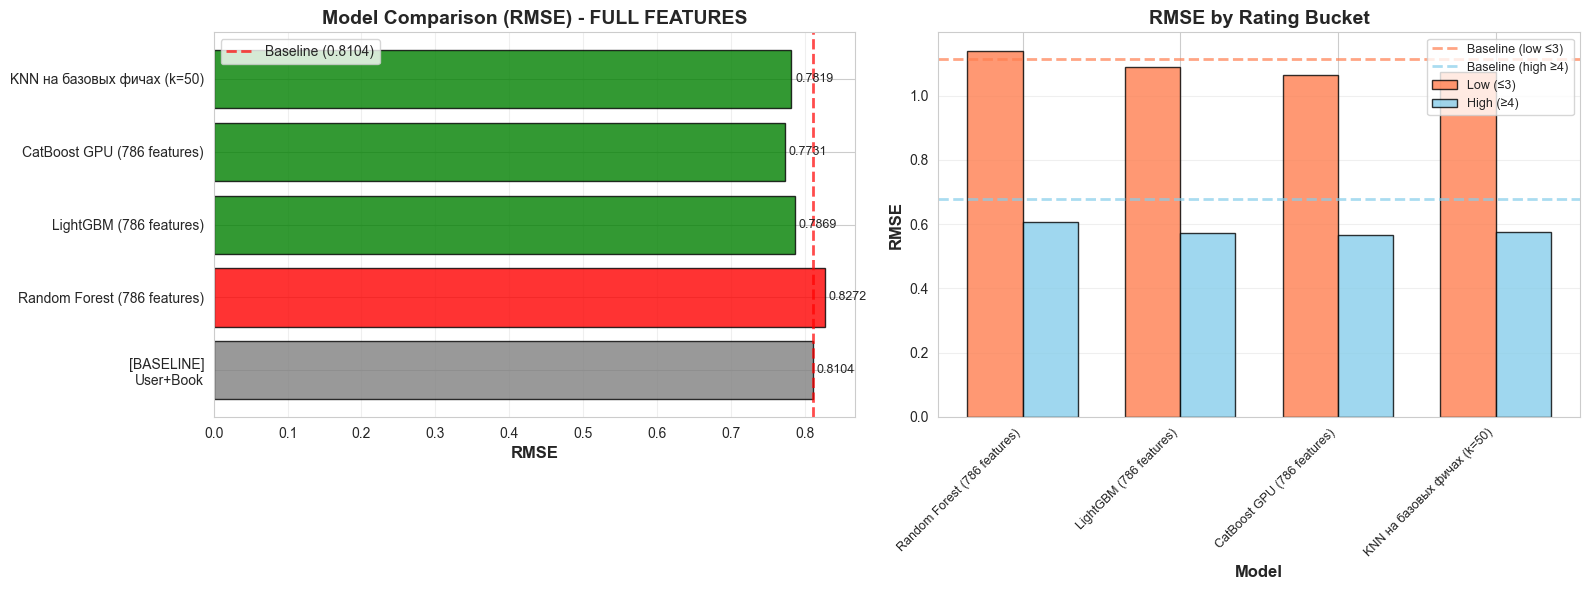

  График: feature_importance_full.png


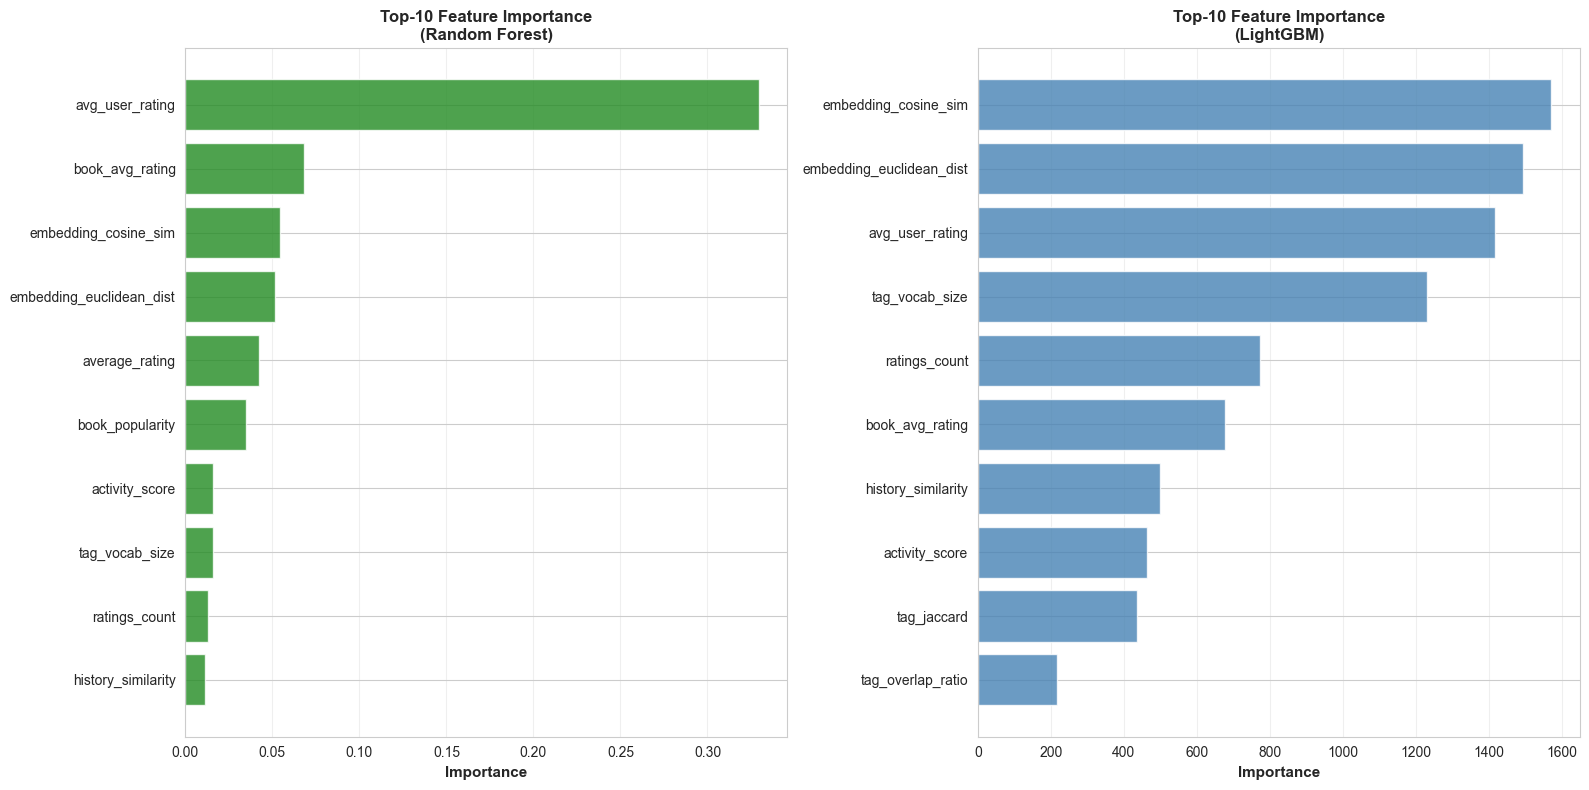

In [ ]:
print("\n" + "="*70)
print("[9/9] СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*70)

results_df = pd.DataFrame(all_results)

print("\n Таблица результатов:")
print(" " + "="*100)
print(f" {'Model':<35} {'RMSE':<10} {'MAE':<10} {'RMSE(low)':<12} {'RMSE(high)':<12} {'Beat':<6}")
print(" " + "="*100)

# Baseline
print(f" {'[BASELINE] User+Book':<35} {baseline_rmse:<10.4f} {'-':<10} {'1.1141':<12} {'0.6770':<12} {'-':<6}")
print(" " + "-"*100)

for _, row in results_df.iterrows():
    
    print(f" {row['model']:<35} {row['rmse']:<10.4f} {row['mae']:<10.4f} "
          f"{row['rmse_low']:<12.4f} {row['rmse_high']:<12.4f} {row['beats_baseline']:<6}")

print(" " + "="*100)

# Статистика
best_model = results_df.loc[results_df['rmse'].idxmin(), 'model']
best_rmse = results_df['rmse'].min()
models_beat = results_df['beats_baseline'].sum()

print(f"\n  Лучшая модель: {best_model}")
print(f" RMSE: {best_rmse:.4f}")
print(f" Улучшение vs baseline: {(baseline_rmse - best_rmse)/baseline_rmse*100:.2f}%")
print(f"\n  Моделей лучше baseline: {models_beat}/{len(results_df)}")

# Визуализация
print("\n" + "="*70)
print(" СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ")
print("="*70)

# График 1: Сравнение RMSE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]

models_all = ['[BASELINE]\nUser+Book'] + results_df['model'].tolist()
rmse_all = [baseline_rmse] + results_df['rmse'].tolist()

colors = ['gray'] + ['green' if beat else 'red' for beat in results_df['beats_baseline']]

bars = ax1.barh(models_all, rmse_all, color=colors, alpha=0.8, edgecolor='black')

ax1.axvline(baseline_rmse, color='red', linestyle='--', linewidth=2,
           label=f'Baseline ({baseline_rmse:.4f})', alpha=0.7)

ax1.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison (RMSE) - FULL FEATURES', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

for i, (bar, value) in enumerate(zip(bars, rmse_all)):
    ax1.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=9)

# График 2: RMSE по buckets
ax2 = axes[1]

x = np.arange(len(results_df))
width = 0.35

bars1 = ax2.bar(x - width/2, results_df['rmse_low'], width,
               label='Low (≤3)', color='coral', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, results_df['rmse_high'], width,
               label='High (≥4)', color='skyblue', alpha=0.8, edgecolor='black')

ax2.axhline(1.1141, color='coral', linestyle='--', alpha=0.7,
           label='Baseline (low ≤3)', linewidth=2)
ax2.axhline(0.6770, color='skyblue', linestyle='--', alpha=0.7,
           label='Baseline (high ≥4)', linewidth=2)

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('RMSE by Rating Bucket', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['model'], rotation=45, ha='right', fontsize=9)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ml_models_full_features.png', dpi=300, bbox_inches='tight')
print("\n  График: ml_models_full_features.png")
plt.show()

# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest importance
ax1 = axes[0]
rf_top10 = feature_importance_rf.head(10).sort_values('importance')
ax1.barh(rf_top10['feature'], rf_top10['importance'], color='forestgreen', alpha=0.8)
ax1.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax1.set_title('Top-10 Feature Importance\n(Random Forest)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# LightGBM importance
ax2 = axes[1]
lgb_top10 = lgb_importance.head(10).sort_values('importance')
ax2.barh(lgb_top10['feature'], lgb_top10['importance'], color='steelblue', alpha=0.8)
ax2.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax2.set_title('Top-10 Feature Importance\n(LightGBM)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_full.png', dpi=300, bbox_inches='tight')
print("  График: feature_importance_full.png")
plt.show()

## 10. Сохранение результатов

In [25]:
print("\n" + "="*70)
print(" СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*70)

# Результаты
results_df.to_csv('ml_models_results_full.csv', index=False)
print("\n  ml_models_results_full.csv")

# Модели
models_dict = {
    'random_forest': rf,
    'lightgbm': lgb_model,
    'catboost': catboost_model,
    'knn_features': knn_features,
    'scaler': scaler,
    'scaler_base': scaler_base,
    'all_features': all_features,
    'base_features': base_features,
    'best_model_name': best_model,
    'best_rmse': best_rmse
}


with open('ml_models_full_features.pkl', 'wb') as f:
    pickle.dump(models_dict, f)

print("  ml_models_full_features.pkl")

# Предсказания
predictions_dict = {
    'random_forest': rf_pred,
    'lightgbm': lgb_pred,
    'catboost': catboost_pred,
    'knn_features': knn_feat_pred,
    'y_test': y_test
}

np.save('ml_predictions_full.npy', predictions_dict)
print("  ml_predictions_full.npy")

# Feature importance
feature_importance_rf.to_csv('feature_importance_rf_full.csv', index=False)
lgb_importance.to_csv('feature_importance_lgb_full.csv', index=False)
print("  feature_importance_rf_full.csv")
print("  feature_importance_lgb_full.csv")

print("\n" + "="*70)
print(" ADVANCED ML MODELS (FULL FEATURES) - ЗАВЕРШЕНО")
print("="*70)

print(f"\n Итоги:")
print(f" • Использовано признаков: {len(all_features)} (18 базовых + 768 embeddings)")
print(f" • Протестировано моделей: {len(results_df)}")
print(f" • Лучшая: {best_model} (RMSE: {best_rmse:.4f})")
print(f" • Baseline: {baseline_rmse:.4f}")
print(f" • Улучшение: {(baseline_rmse - best_rmse)/baseline_rmse*100:.2f}%")
print(f" • Моделей лучше baseline: {models_beat}/{len(results_df)}")




 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

  ml_models_results_full.csv
  ml_models_full_features.pkl
  ml_predictions_full.npy
  feature_importance_rf_full.csv
  feature_importance_lgb_full.csv

 ADVANCED ML MODELS (FULL FEATURES) - ЗАВЕРШЕНО

 Итоги:
 • Использовано признаков: 786 (18 базовых + 768 embeddings)
 • Протестировано моделей: 4
 • Лучшая: CatBoost GPU (786 features) (RMSE: 0.7731)
 • Baseline: 0.8104
 • Улучшение: 4.60%
 • Моделей лучше baseline: 3/4
